In [1]:
################################################### IMPORT #########################################################
# importing of all needed libraries and modules.  
import wrangle as w
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")


In [2]:
train, validate, test=w.wrangle_zillow()

In [3]:
train.head()

,fips,bedrooms,bathrooms,squarefeet,home_value,fips_encoded
6115,6059.0,4.0,3.0,2102.0,806181.0,2
3927,6111.0,3.0,2.5,1766.0,569000.0,3
34641,6037.0,3.0,2.0,1326.0,150537.0,1
5279,6037.0,4.0,3.0,2709.0,151552.0,1
39179,6059.0,3.0,2.5,1460.0,435071.0,2


In [4]:
train.shape

(25986, 6)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25986 entries, 6115 to 581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   fips          25986 non-null  float64
 1   bedrooms      25986 non-null  float64
 2   bathrooms     25986 non-null  float64
 3   squarefeet    25986 non-null  float64
 4   home_value    25986 non-null  float64
 5   fips_encoded  25986 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.4 MB


In [6]:
train.describe()

,fips,bedrooms,bathrooms,squarefeet,home_value,fips_encoded
count,25986.000000,25986.000000,25986.000000,25986.000000,25986.000000,25986.000000
mean,6049.172093,3.207419,2.124779,1727.796044,368824.324482,1.434734
std,21.310931,0.836626,0.786128,681.090511,235146.174368,0.647780
min,6037.000000,1.000000,1.000000,152.000000,1000.000000,1.000000
25%,6037.000000,3.000000,2.000000,1235.000000,173363.000000,1.000000
50%,6037.000000,3.000000,2.000000,1573.000000,336800.000000,1.000000
75%,6059.000000,4.000000,2.500000,2088.000000,522743.750000,2.000000
max,6111.000000,5.000000,5.000000,4976.000000,999937.000000,3.000000


EXPLORATION: Use python libraries: pandas, statsmodels, scipy, numpy, matplotlib, seaborn, scikit-learn.
Perform statistical testing to understand correlations, significant differences in variables, variable interdependencies, etc.
Create visualizations that demonstrate relationships across and within attributes and target.
Use domain knowledge and/or information gained through exploration to construct new features.
Remove features that are noisy, provide no valuable or new information, or are redundant.
Use scikit-learn's preprocessing algorithms (feature selection, feature engineering, dummy variables, binning, clustering, e.g.) to turn attributes into features.

The .corr() method allowed me to not only see what correlates with the target variable, but how they correlate with each other.  It appears that bedrooms and bathrooms are a correlating factor.  Both have have a higher correlation with square feet, bedrooms at .65, but bathrooms is much higher at .81.

In [7]:
spearman_train_corr= train.corr(method='spearman')
spearman_train_corr

,fips,bedrooms,bathrooms,squarefeet,home_value,fips_encoded
fips,1.000000,0.174709,0.206657,0.202285,0.209850,1.000000
bedrooms,0.174709,1.000000,0.606813,0.647345,0.233324,0.174709
bathrooms,0.206657,0.606813,1.000000,0.808784,0.386688,0.206657
squarefeet,0.202285,0.647345,0.808784,1.000000,0.419885,0.202285
home_value,0.209850,0.233324,0.386688,0.419885,1.000000,0.209850
fips_encoded,1.000000,0.174709,0.206657,0.202285,0.209850,1.000000


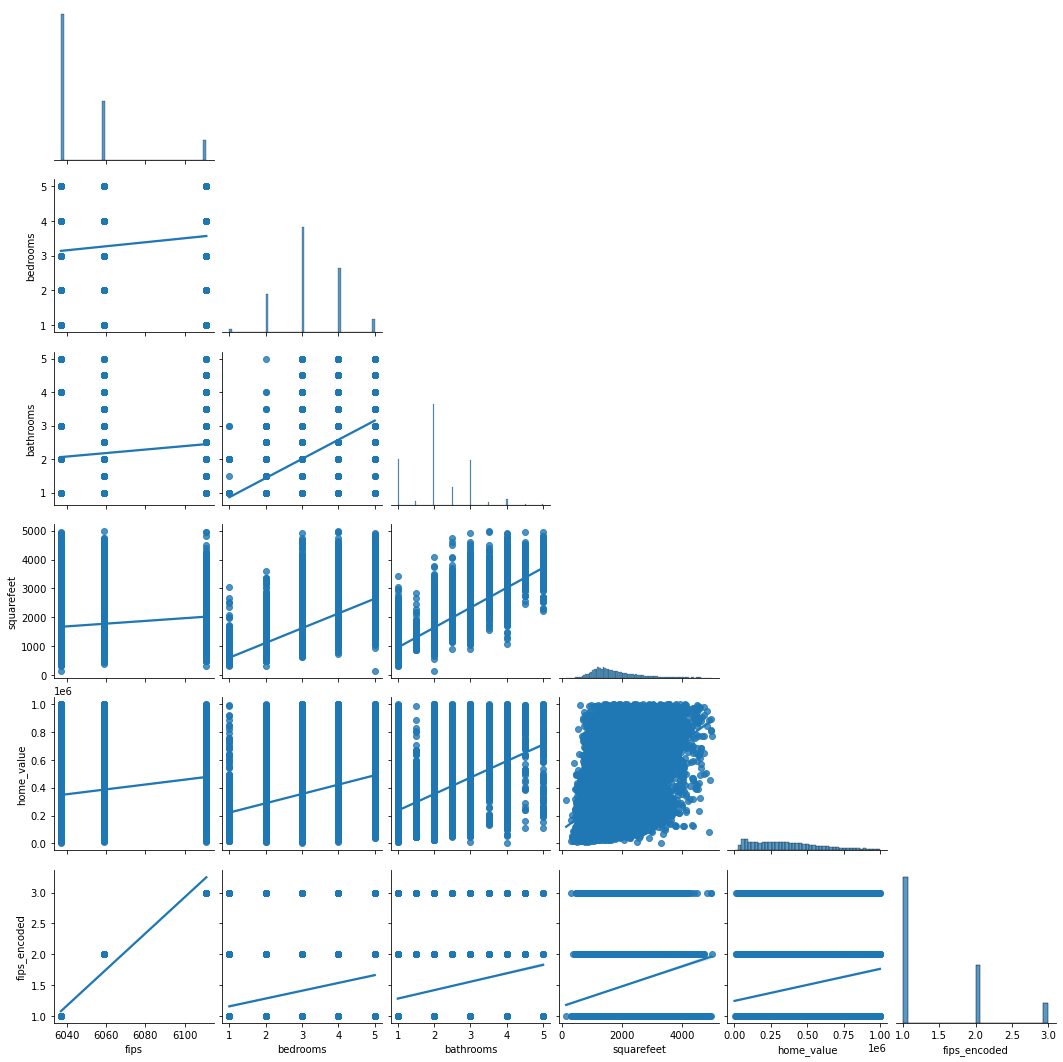

In [8]:
sns.pairplot(data=train, kind="reg", corner=True)

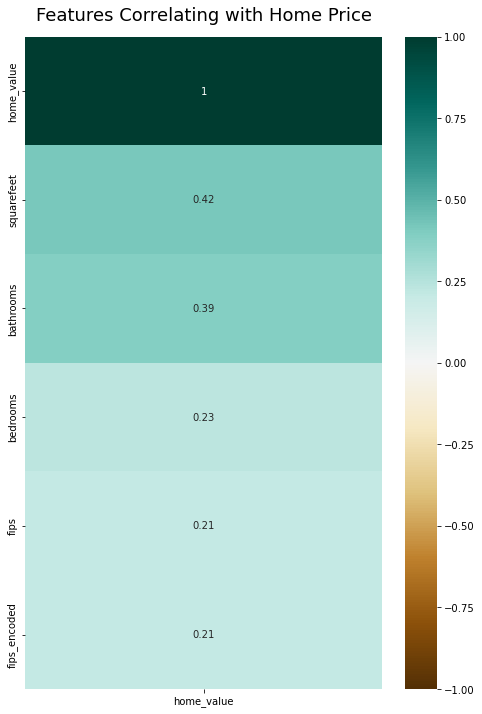

In [9]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr(method='spearman')[['home_value']].sort_values(by='home_value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Home Price', fontdict={'fontsize':18}, pad=16);

In [10]:
# Use a scipy stats function spearmanr to calculate the correlation coefficient and the p-value.
def spearman_test(df, target_var, test_var):
    r, p_value = spearmanr(train[target_var], df[test_var])
    print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

In [11]:
spearman_test(train, 'home_value', 'bedrooms')

Correlation Coefficient: 0.23332401774221348
P-value: 0.0


In [12]:
spearman_test(train, 'home_value', 'bathrooms')

Correlation Coefficient: 0.38668793751190295
P-value: 0.0


In [13]:
spearman_test(train, 'home_value', 'squarefeet')

Correlation Coefficient: 0.41988521240646987
P-value: 0.0


The variables 'bedrooms', 'bathrooms', 'squarefeet' have p values of 0 which shows a significant correlation between them and the target variable, home value.

Based on my correlation coefficient and my p-value, I reject my Null hypothesis that there is no correlation between independent variables of bedrooms, bathrooms, and square feet and target variable of home value.

Although all of the independent variables have positive correlations with the target variable, squarefeet is more correlated. This looks to be the best predictor of our target variable. I will  perform a simple linear regression first. If I want to go back and do some feature engineering with my other independent variables, I could do that and see if I can improve on my accuracy. And since bathrooms is highly correlated with square feet, I might use that.

SCALING

In [14]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale = ['bedrooms', 'bathrooms', 'squarefeet'],
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    scaler = MinMaxScaler()
    #     fit the thing
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [15]:
scaler, train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, return_scaler=True)

In [16]:
def visualize_scaler(scaler, df, columns_to_scale, bins=10):
    fig, axs = plt.subplots(len(columns_to_scale), 2, figsize=(16,9))
    df_scaled = df.copy()
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    for (ax1, ax2), col in zip(axs, columns_to_scale):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()
#return fig, axs

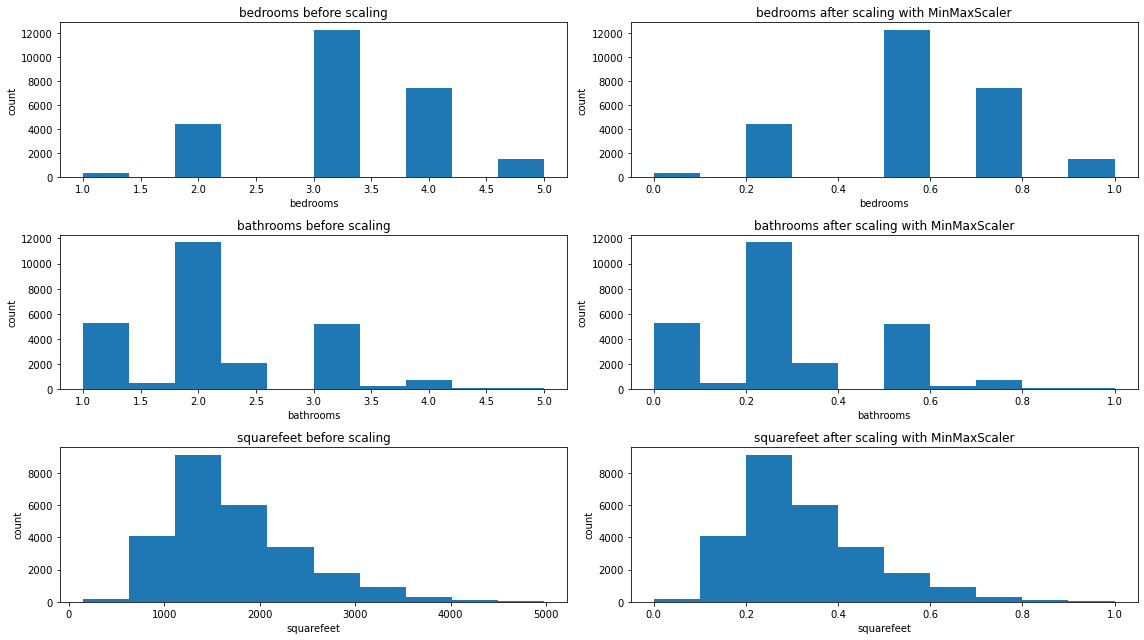

In [17]:
# MinMaxScaler Applied
visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 columns_to_scale=['bedrooms', 'bathrooms', 'squarefeet'], 
                 bins=10)

In [18]:
train_scaled.corr()

,fips,bedrooms,bathrooms,squarefeet,home_value,fips_encoded
fips,1.000000,0.146923,0.141619,0.148102,0.158003,0.964440
bedrooms,0.146923,1.000000,0.608971,0.627040,0.237931,0.163307
bathrooms,0.141619,0.608971,1.000000,0.797478,0.395580,0.166058
squarefeet,0.148102,0.627040,0.797478,1.000000,0.458490,0.170810
home_value,0.158003,0.237931,0.395580,0.458490,1.000000,0.188331
fips_encoded,0.964440,0.163307,0.166058,0.170810,0.188331,1.000000


In [19]:
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25986 entries, 6115 to 581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   fips          25986 non-null  float64
 1   bedrooms      25986 non-null  float64
 2   bathrooms     25986 non-null  float64
 3   squarefeet    25986 non-null  float64
 4   home_value    25986 non-null  float64
 5   fips_encoded  25986 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 2.4 MB


MODELING

In [20]:
X_train_scaled=train_scaled.drop(columns=['home_value'])
y_train=train_scaled.home_value

In [21]:
X_validate_scaled=validate_scaled.drop(columns=['home_value'])
y_validate=validate_scaled.home_value

In [22]:
X_test_scaled=test_scaled.drop(columns=['home_value'])
y_test=test_scaled.home_value

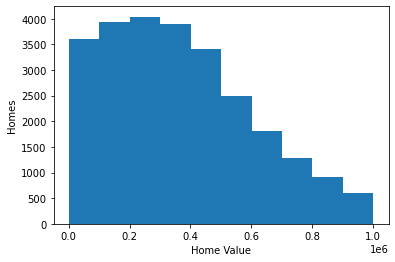

In [23]:
plt.hist(y_train)
plt.xlabel("Home Value")
plt.ylabel("Homes")
plt.show()


In [24]:
home_value_pred_mean = y_train.mean()

In [25]:
home_value_pred_mean

368824.3244824136

In [26]:
home_value_pred_median = y_train.median()

In [27]:
home_value_pred_median

336800.0

In [28]:
y_train.head()

6115     806181.0
3927     569000.0
34641    150537.0
5279     151552.0
39179    435071.0
Name: home_value, dtype: float64

BASELINE

In [29]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict home_value_pred_mean
home_value_pred_mean = y_train['home_value'].mean()
y_train['home_value_pred_mean'] = home_value_pred_mean
y_validate['home_value_pred_mean'] = home_value_pred_mean

# 2. compute home_value_pred_median
home_value_pred_median = y_train['home_value'].median()
y_train['home_value_pred_median'] = home_value_pred_median
y_validate['home_value_pred_median'] = home_value_pred_median

# 3. RMSE of home_value_pred_mean
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of home_value_pred_median
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  235141.65 
Validate/Out-of-Sample:  234344.53
RMSE using Median
Train/In-Sample:  237312.35 
Validate/Out-of-Sample:  236131.18


In [30]:
y_train.head()

,home_value,home_value_pred_mean,home_value_pred_median
6115,806181.0,368824.324482,336800.0
3927,569000.0,368824.324482,336800.0
34641,150537.0,368824.324482,336800.0
5279,151552.0,368824.324482,336800.0
39179,435071.0,368824.324482,336800.0


OLS

In [31]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm)**(1/2)

# predict validate
y_validate['home_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  205621.559002793 
Validation/Out-of-Sample:  204613.69866068155


In [32]:
y_validate.head()

,home_value,home_value_pred_mean,home_value_pred_median,home_value_pred_lm
3015,893000.0,368824.324482,336800.0,653125.686607
38407,358970.0,368824.324482,336800.0,346649.648159
11805,406087.0,368824.324482,336800.0,855606.786505
47143,523390.0,368824.324482,336800.0,251069.661602
2425,509655.0,368824.324482,336800.0,362356.384097


POLYNOMIAL REGRESSION degree 2

In [33]:
from sklearn.preprocessing import PolynomialFeatures
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [34]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.home_value)

# predict train
y_train['home_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm2)**(1/2)

# predict validate
y_validate['home_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  206977.1443859872 
Validation/Out-of-Sample:  205248.1644044736


POLYNOMIAL REGRESSION degree 3

In [35]:
from sklearn.preprocessing import PolynomialFeatures
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled)
X_test_degree3 = pf.transform(X_test_scaled)

In [36]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.home_value)

# predict train
y_train['home_value_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm3)**(1/2)

# predict validate
y_validate['home_value_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  204405.88035151872 
Validation/Out-of-Sample:  203196.66691106698


LASSOLARS

In [37]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lars)**(1/2)

# predict validate
y_validate['home_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  205625.4377941296 
Validation/Out-of-Sample:  204616.62750663006


In [38]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_glm)**(1/2)

# predict validate
y_validate['home_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  205621.5590027932 
Validation/Out-of-Sample:  204613.69857513605


EVALUATE

In [39]:
y_validate.head()

,home_value,home_value_pred_mean,home_value_pred_median,home_value_pred_lm,home_value_pred_lm2,home_value_pred_lm3,home_value_pred_lars,home_value_pred_glm
3015,893000.0,368824.324482,336800.0,653125.686607,655360.0,698368.0,650980.968017,653125.673392
38407,358970.0,368824.324482,336800.0,346649.648159,262144.0,313344.0,348853.007677,346649.633919
11805,406087.0,368824.324482,336800.0,855606.786505,786432.0,836608.0,852924.768232,855606.764561
47143,523390.0,368824.324482,336800.0,251069.661602,262144.0,245760.0,252162.074450,251069.664127
2425,509655.0,368824.324482,336800.0,362356.384097,344064.0,352256.0,360521.119276,362356.386046


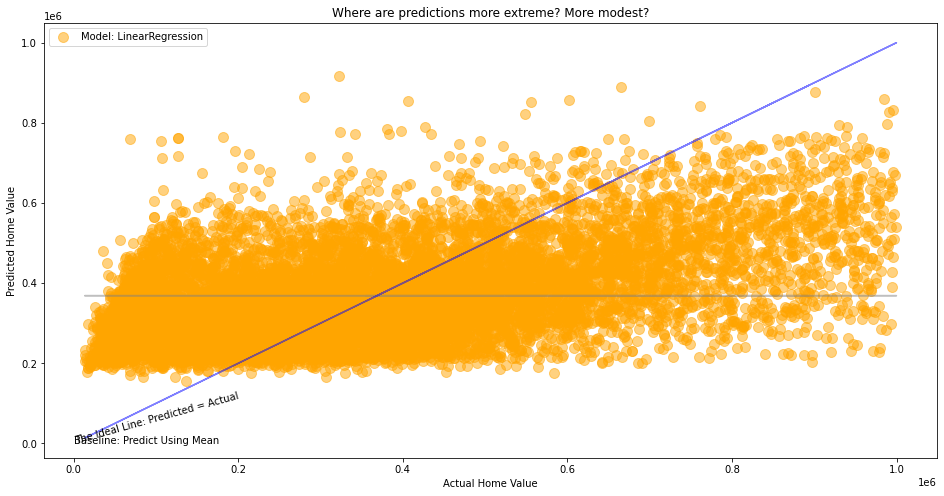

In [40]:

plt.figure(figsize=(16,8))
plt.plot(y_validate.home_value, y_validate.home_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.home_value, y_validate.home_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.home_value, y_validate.home_value_pred_lm, 
            alpha=.5, color="orange", s=100, label="Model: LinearRegression")

plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


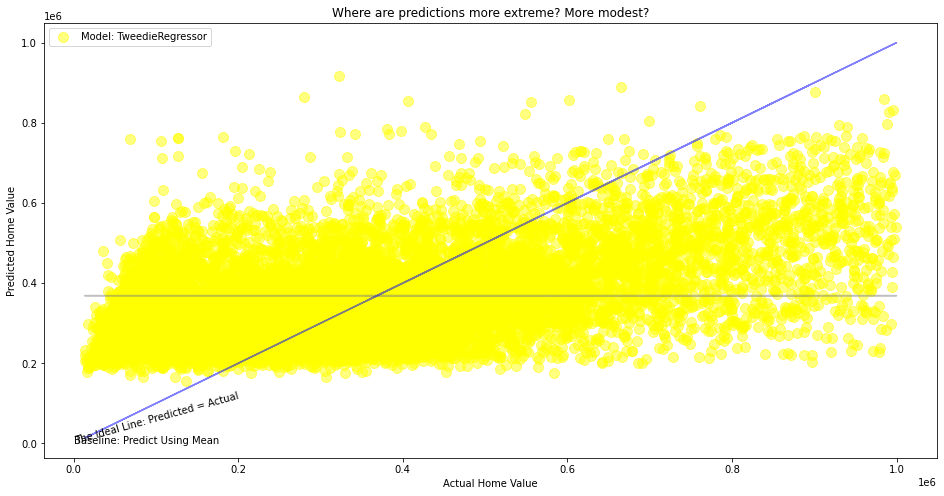

In [41]:

plt.figure(figsize=(16,8))
plt.plot(y_validate.home_value, y_validate.home_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.home_value, y_validate.home_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.home_value, y_validate.home_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")

plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


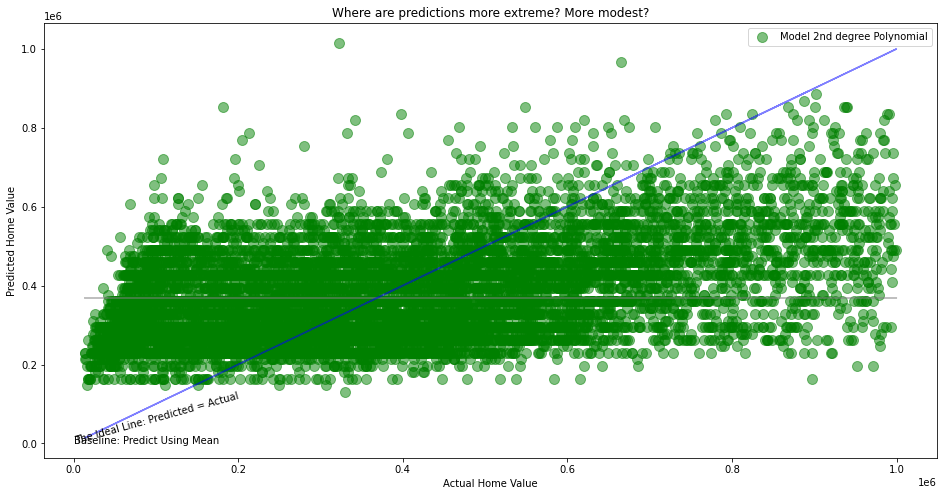

In [42]:

plt.figure(figsize=(16,8))
plt.plot(y_validate.home_value, y_validate.home_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.home_value, y_validate.home_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)


plt.scatter(y_validate.home_value, y_validate.home_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")

plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


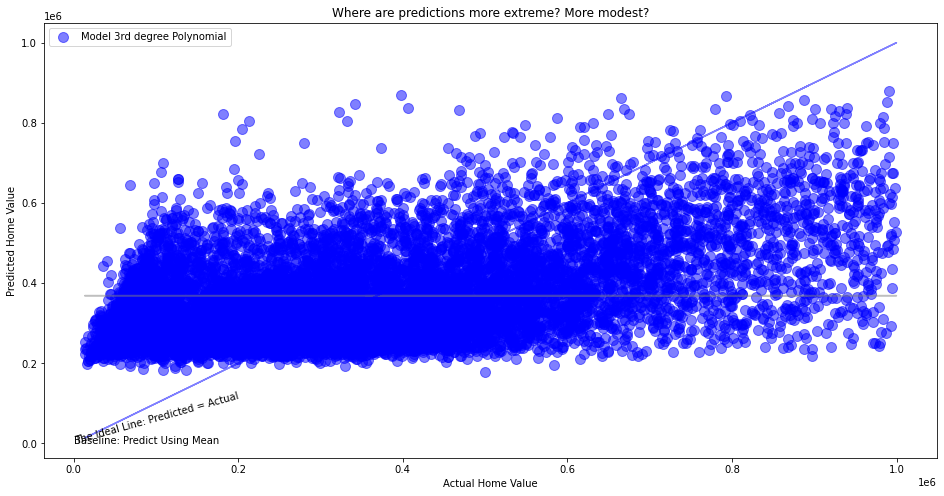

In [43]:

plt.figure(figsize=(16,8))
plt.plot(y_validate.home_value, y_validate.home_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.home_value, y_validate.home_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.home_value, y_validate.home_value_pred_lm3, 
            alpha=.5, color="blue", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


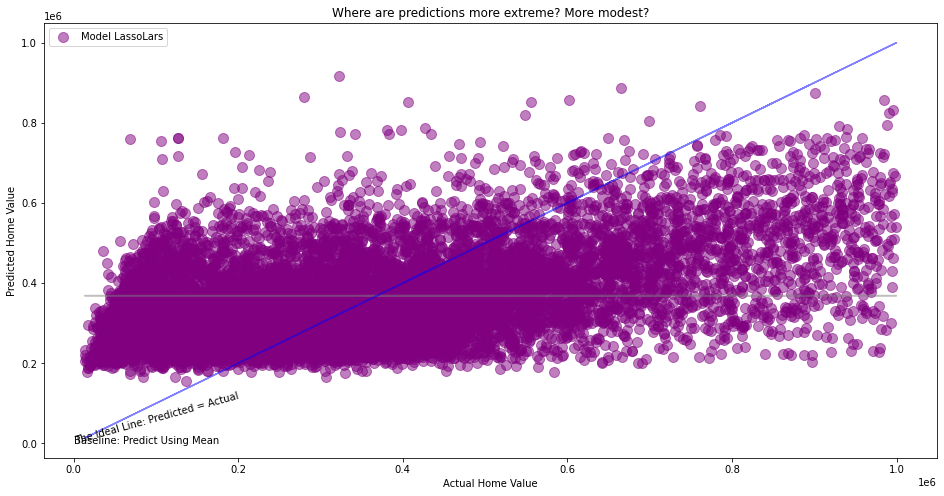

In [44]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.home_value, y_validate.home_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.home_value, y_validate.home_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.home_value, y_validate.home_value_pred_lars, 
            alpha=.5, color="purple", s=100, label="Model LassoLars")
plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


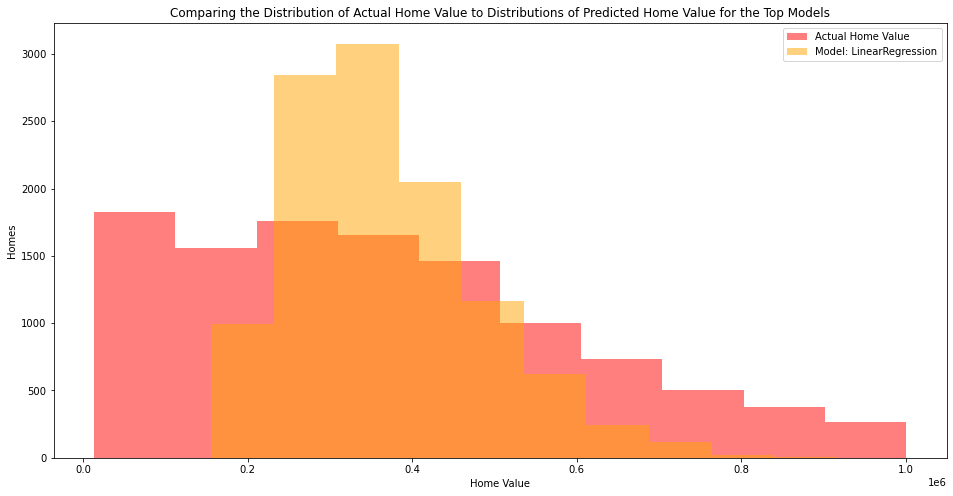

In [45]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.home_value, color='red', alpha=.5, label="Actual Home Value")
plt.hist(y_validate.home_value_pred_lm, color='orange', alpha=.5, label="Model: LinearRegression")

plt.xlabel("Home Value")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Actual Home Value to Distributions of Predicted Home Value for the Top Models")
plt.legend()
plt.show()

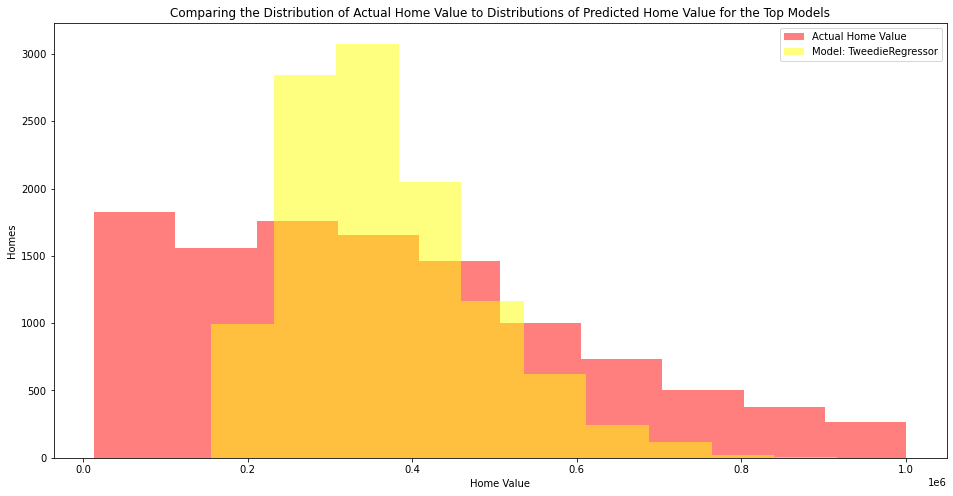

In [46]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.home_value, color='red', alpha=.5, label="Actual Home Value")
plt.hist(y_validate.home_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")

plt.xlabel("Home Value")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Actual Home Value to Distributions of Predicted Home Value for the Top Models")
plt.legend()
plt.show()

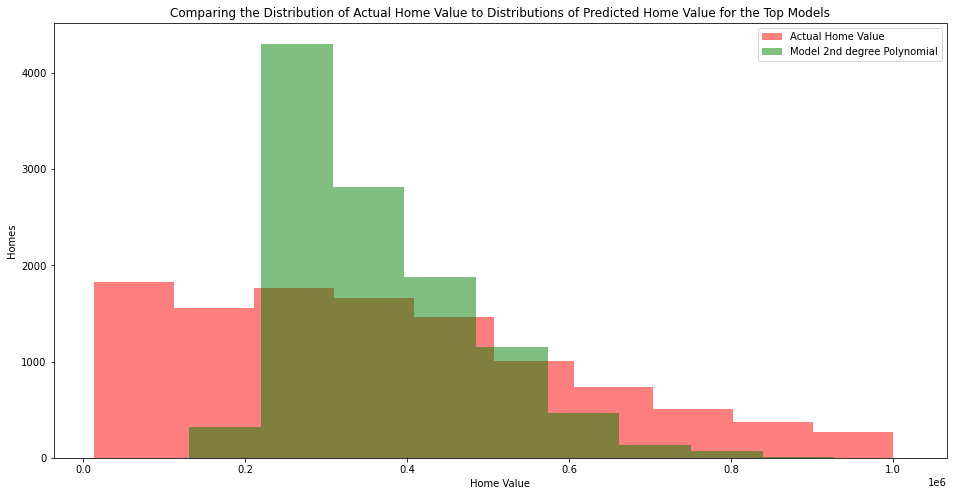

In [47]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.home_value, color='red', alpha=.5, label="Actual Home Value")
plt.hist(y_validate.home_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")

plt.xlabel("Home Value")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Actual Home Value to Distributions of Predicted Home Value for the Top Models")
plt.legend()
plt.show()

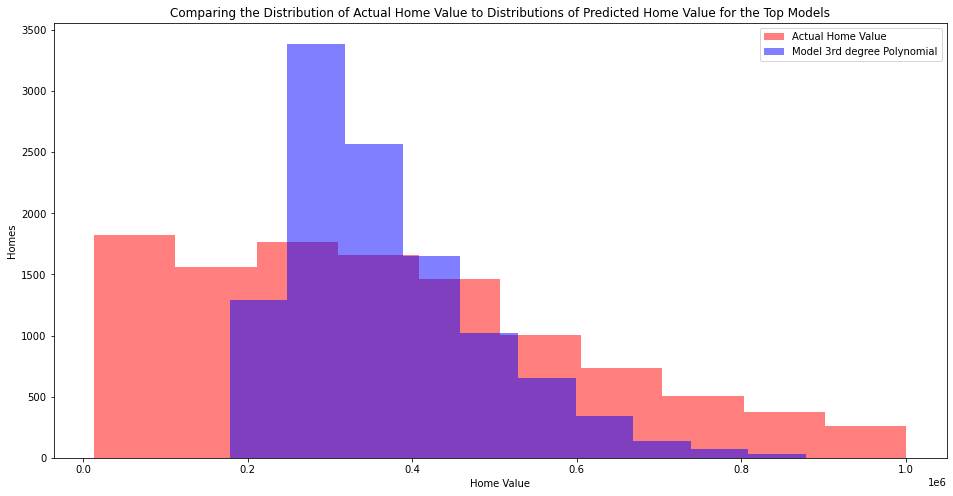

In [48]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.home_value, color='red', alpha=.5, label="Actual Home Value")
plt.hist(y_validate.home_value_pred_lm3, color='blue', alpha=.5, label="Model 3rd degree Polynomial")

plt.xlabel("Home Value")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Actual Home Value to Distributions of Predicted Home Value for the Top Models")
plt.legend()
plt.show()

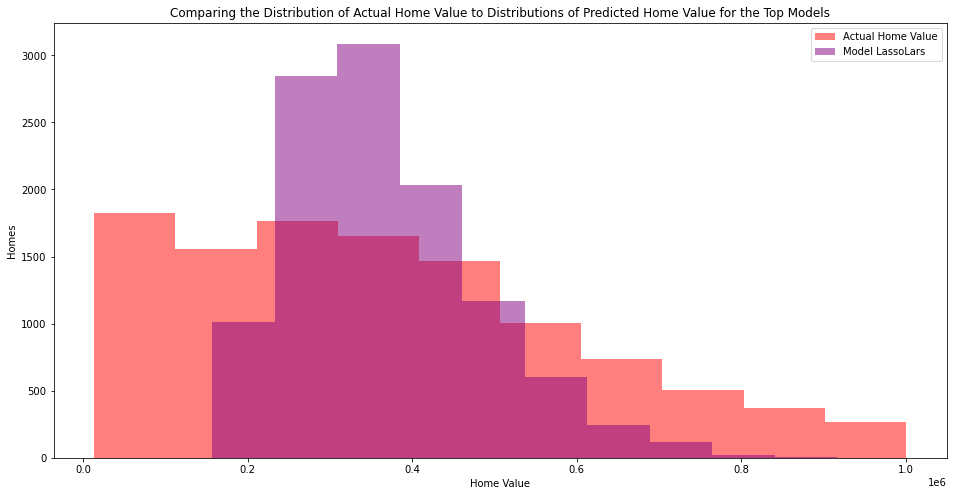

In [49]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.home_value, color='red', alpha=.5, label="Actual Home Value")
plt.hist(y_validate.home_value_pred_lars, color='purple', alpha=.5, label="Model LassoLars")

plt.xlabel("Home Value")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Actual Home Value to Distributions of Predicted Home Value for the Top Models")
plt.legend()
plt.show()